In [1]:
!pip install transformers torch datasets
!pip install pandas spacy tensorflow imbalanced-learn
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.loa

In [2]:
# Import required libraries
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Capstone Material/Hyperparameter Tuned/Datasets/spelling_correct_with_removeNumber - spelling_correct_with_removeNumber.csv')
df

,sentence,labels
0,in going to go,0
1,in going to say goodby to the drugstore,0
2,i think that this is the way it should be done...,0
3,in going to join you,0
4,its illegal,0
...,...,...
25565,i saw that there are people like musfakur him ...,0
25566,papa she is trying to avoid responsibility here,0
25567,said needs the bangladesh team,0
25568,you keep going we ll take your shot,0


# **Word Cloud**

In [5]:
# Install necessary libraries
!pip install wordcloud pandas matplotlib

# Import necessary libraries
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
# Replace 'path_to_hate_speech.csv' with the actual path to your dataset
dataset_path = "/content/drive/MyDrive/Capstone Material/Hyperparameter Tuned/Datasets/spelling_correct_with_removeNumber - spelling_correct_with_removeNumber.csv"  # MODIFY this to the actual dataset path
df = pd.read_csv(dataset_path)

# Preview the dataset
print("Dataset preview:")
print(df.head())

Dataset preview:
                                            sentence  labels
0                                     in going to go       0
1            in going to say goodby to the drugstore       0
2  i think that this is the way it should be done...       0
3                               in going to join you       0
4                                        its illegal       0


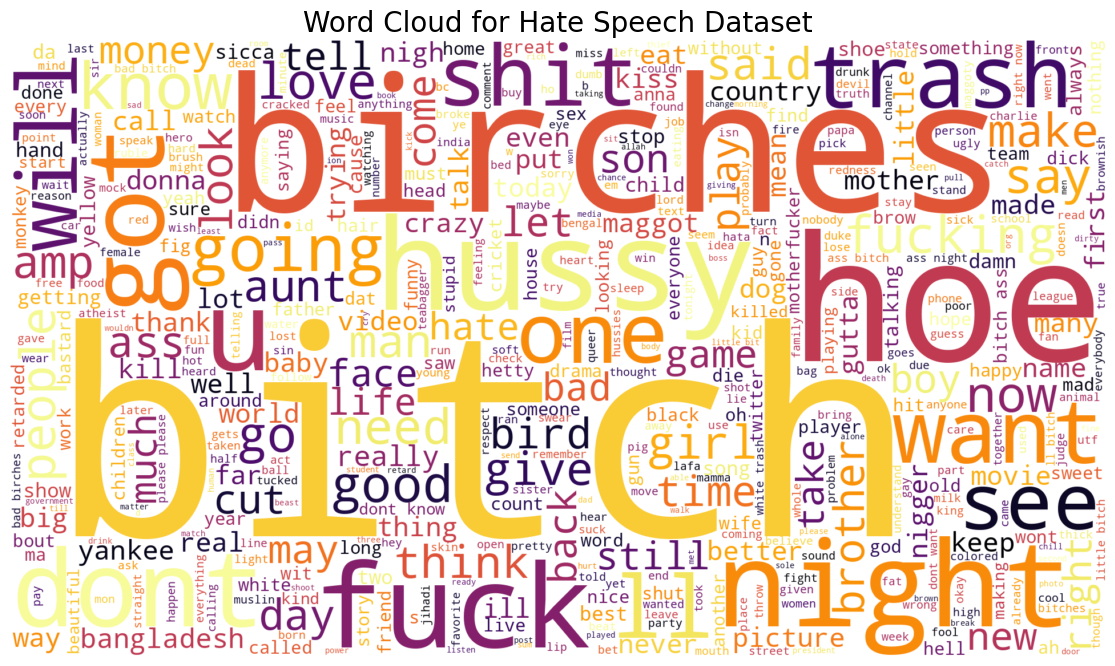

In [6]:
# Check for the column containing text data
# MODIFY 'text' to the actual column name that contains the text
text_data = df['sentence']

# Combine all text into a single string
text = " ".join(str(text) for text in text_data)

# Generate the word cloud
wordcloud = WordCloud(
    width=1920,
    height=1080,
    background_color='white',
    colormap='inferno',
    max_words=500
).generate(text)

# Display the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Word Cloud for Hate Speech Dataset", fontsize=20)
plt.show()

In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['sentence'], df['labels'], test_size=0.2, random_state=128)

In [8]:
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Tokenize the training and testing data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [9]:
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the datasets
train_dataset = HateSpeechDataset(train_encodings, list(train_labels))
test_dataset = HateSpeechDataset(test_encodings, list(test_labels))

In [11]:
# Install necessary libraries
!pip install transformers -qq
!pip install torch -qq
!pip install matplotlib -qq

# Import necessary libraries
import os
import matplotlib.pyplot as plt
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset  # This is optional, use if you want to load data using Hugging Face Datasets library

# Deactivate wandb logging
os.environ["WANDB_DISABLED"] = "true"

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)

# Define your training and validation datasets (e.g., Hugging Face Datasets library can be used to load them)
# Example (replace this with loading your own data if needed):
# dataset = load_dataset('your_dataset_here')
# train_dataset = dataset['train']
# test_dataset = dataset['test']

from sklearn.metrics import accuracy_score

# Update the custom callback to track accuracy as well
class AccuracyHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'accuracy' in logs:
                self.train_accuracies.append(logs['accuracy'])

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            if 'eval_loss' in metrics:
                self.eval_losses.append(metrics['eval_loss'])
            if 'eval_accuracy' in metrics:
                self.eval_accuracies.append(metrics['eval_accuracy'])

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# Initialize the updated callback
accuracy_callback = AccuracyHistoryCallback()

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # Use a smaller epoch count for faster testing
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"  # Runs evaluation at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[accuracy_callback],
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-11-74519351ae13>:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.339500,0.290473,0.894603
2,0.130700,0.315086,0.898709
3,0.143700,0.352609,0.903794
4,0.094200,0.454260,0.902425
5,0.002700,0.525223,0.901838


TrainOutput(global_step=12785, training_loss=0.21496019244360118, metrics={'train_runtime': 2098.4535, 'train_samples_per_second': 48.741, 'train_steps_per_second': 6.093, 'total_flos': 3387191383633920.0, 'train_loss': 0.21496019244360118, 'epoch': 5.0})

In [12]:
predictions, labels, _ = trainer.predict(test_dataset)  # Get raw predictions and labels
predicted_labels = np.argmax(predictions, axis=1)

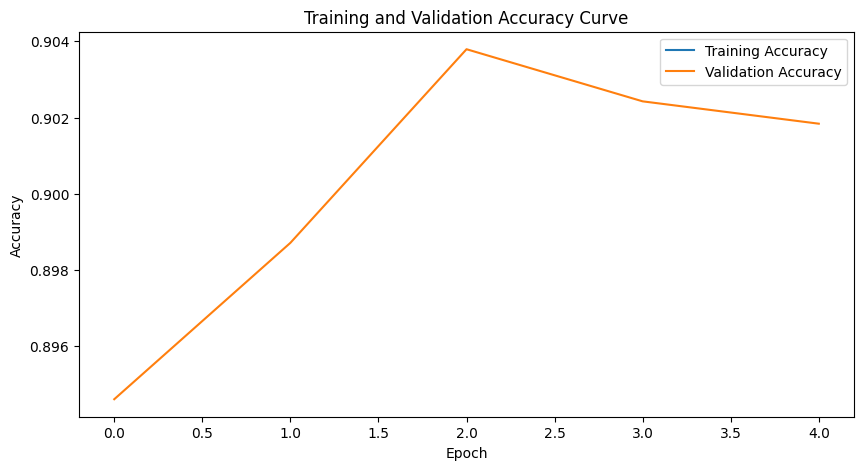

In [13]:
# Plot training and validation accuracy curves after training
plt.figure(figsize=(10, 5))
plt.plot(accuracy_callback.train_accuracies, label='Training Accuracy')
plt.plot(accuracy_callback.eval_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.show()

# **Plot the training and validation loss curves**

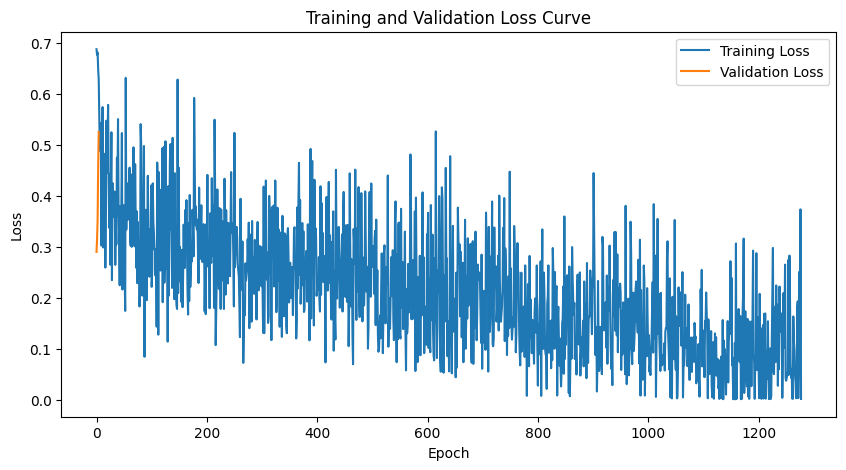

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(accuracy_callback.train_losses, label="Training Loss")
plt.plot(accuracy_callback.eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

In [15]:
accuracy = accuracy_score(labels, predicted_labels)

# Print the accuracy
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9018


# **Confusion Matrix**
Source: https://youtu.be/8gLewErTU24?si=IYIN6qnx0ylYFSok

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
confusion_matrix(test_labels, predicted_labels)

array([[1963,  241],
       [ 261, 2649]])

In [18]:
#Getting dataframe labels

from sklearn.utils.multiclass import unique_labels
unique_labels(test_labels)

array([0, 1])

In [19]:
#Combining these labels with the confusion matrix

def plot(y_true, y_pred):
  labels = unique_labels(test_labels)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)

  return table

In [20]:
plot(test_labels, predicted_labels)

,Predicted 0,Predicted 1
Actual 0,1963,241
Actual 1,261,2649


In [21]:
def plot2(y_true, y_pred):
  labels = unique_labels(test_labels)
  column = [f'Predicted {label}' for label in labels]
  indices = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=column, index=indices)

  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

<Axes: >

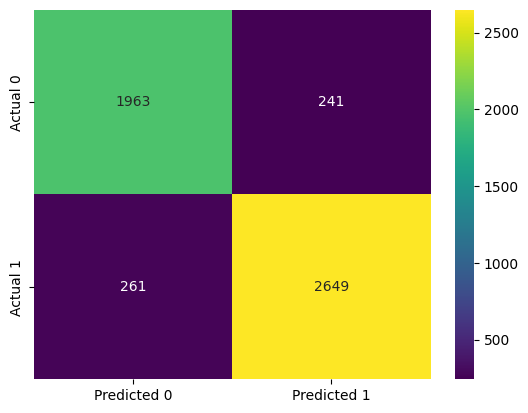

In [22]:
plot2(test_labels, predicted_labels)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2204
           1       0.92      0.91      0.91      2910

    accuracy                           0.90      5114
   macro avg       0.90      0.90      0.90      5114
weighted avg       0.90      0.90      0.90      5114



# **ROC and AUC**
Source: https://github.com/Suji04/Diabetes-Detection/blob/master/ROC%20AUC%20demo.ipynb

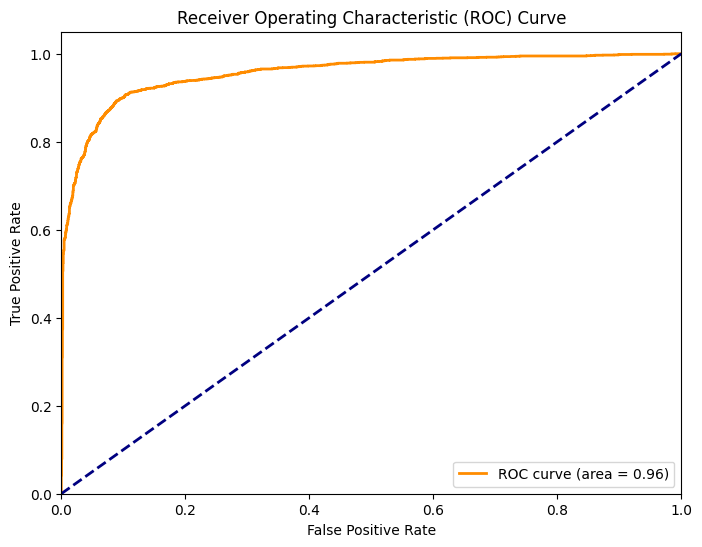

AUC: 0.96


In [24]:
# Import necessary libraries for ROC and AUC
from sklearn.metrics import roc_curve, auc
import numpy as np
import torch

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Convert logits to probabilities
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()  # Take the probability of the positive class
true_labels = predictions.label_ids  # True labels from the dataset

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display AUC
print(f"AUC: {roc_auc:.2f}")

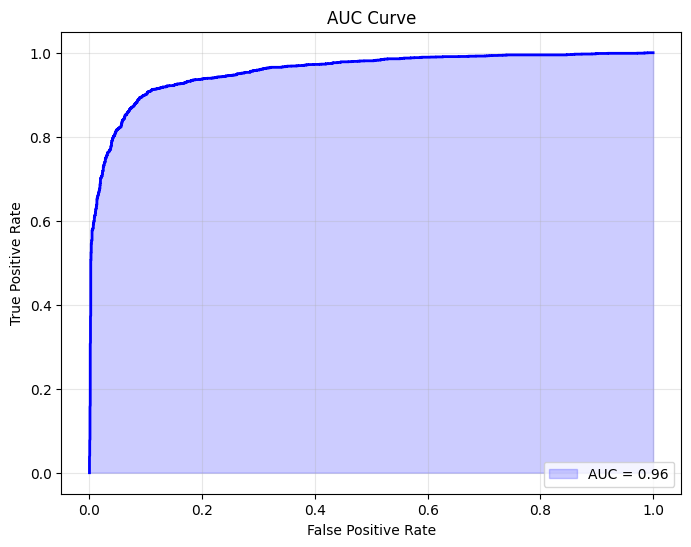

In [25]:
# Plot the AUC curve separately
plt.figure(figsize=(8, 6))
plt.fill_between(fpr, tpr, color='blue', alpha=0.2, label=f'AUC = {roc_auc:.2f}')
plt.plot(fpr, tpr, color='blue', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# **K Fold Cross Validation**

In [26]:
import torch
from torch.utils.data import DataLoader, Subset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#class HateSpeechDataset(torch.utils.data.Dataset):

# Define your dataset (modify this section)
# Ensure train_dataset is a Hugging Face Dataset or a compatible PyTorch Dataset
# Example (replace this with your actual data):
# dataset = load_dataset('your_dataset_here')
# train_dataset = dataset['train']
# labels = train_dataset['labels']  # Extract labels for splitting

# Replace the following with your actual dataset
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels): # Added encodings and labels as input
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset = HateSpeechDataset(train_encodings, train_labels)
labels = train_labels

# Initialize K-Fold Cross-Validation
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Initialize callback
accuracy_callback = AccuracyHistoryCallback()

# Cross-validation loop
fold_results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset, labels)):
    print(f"Starting Fold {fold + 1}/{NUM_FOLDS}")

    # Split dataset into train and validation sets
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # Evaluate the model
    eval_metrics = trainer.evaluate()
    print(f"Fold {fold + 1} - Evaluation Metrics: {eval_metrics}")

    fold_results.append(eval_metrics['eval_accuracy'])

# Print overall results
print(f"K-Fold Cross-Validation Results: {fold_results}")
print(f"Mean Accuracy: {sum(fold_results) / len(fold_results):.4f}")

Starting Fold 1/5


Fold 1 - Evaluation Metrics: {'eval_loss': 0.5252229571342468, 'eval_accuracy': 0.9018380915134924, 'eval_runtime': 12.3634, 'eval_samples_per_second': 413.641, 'eval_steps_per_second': 51.766, 'epoch': 5.0}
Starting Fold 2/5
Fold 2 - Evaluation Metrics: {'eval_loss': 0.5252229571342468, 'eval_accuracy': 0.9018380915134924, 'eval_runtime': 12.9174, 'eval_samples_per_second': 395.9, 'eval_steps_per_second': 49.546, 'epoch': 5.0}
Starting Fold 3/5
Fold 3 - Evaluation Metrics: {'eval_loss': 0.5252229571342468, 'eval_accuracy': 0.9018380915134924, 'eval_runtime': 12.8949, 'eval_samples_per_second': 396.592, 'eval_steps_per_second': 49.632, 'epoch': 5.0}
Starting Fold 4/5
Fold 4 - Evaluation Metrics: {'eval_loss': 0.5252229571342468, 'eval_accuracy': 0.9018380915134924, 'eval_runtime': 12.8547, 'eval_samples_per_second': 397.833, 'eval_steps_per_second': 49.787, 'epoch': 5.0}
Starting Fold 5/5
Fold 5 - Evaluation Metrics: {'eval_loss': 0.5252229571342468, 'eval_accuracy': 0.9018380915134924

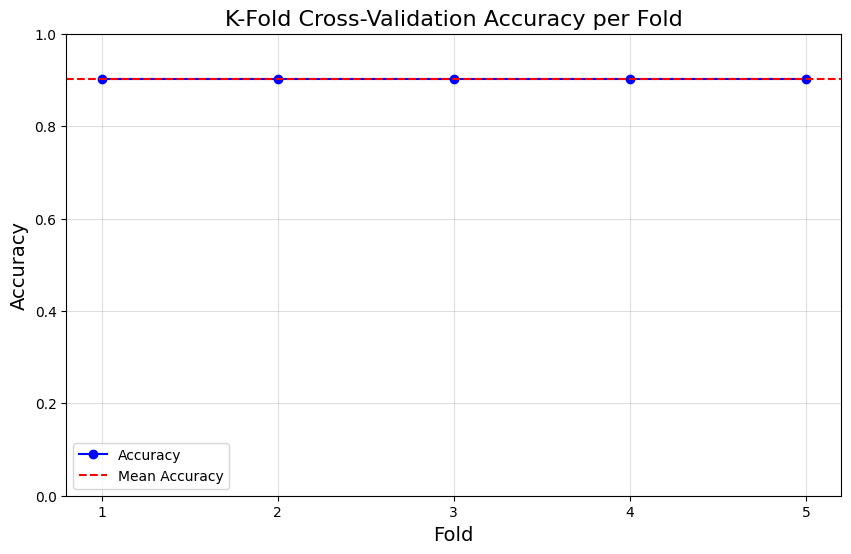

In [27]:
import matplotlib.pyplot as plt

# K-Fold Cross-Validation Results Visualization
folds = list(range(1, NUM_FOLDS + 1))  # Fold numbers

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(folds, fold_results, marker='o', linestyle='-', color='b', label='Accuracy')
plt.axhline(y=sum(fold_results) / len(fold_results), color='r', linestyle='--', label='Mean Accuracy')  # Mean accuracy line

# Add labels and title
plt.title('K-Fold Cross-Validation Accuracy per Fold', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(folds)  # Set x-axis ticks to fold numbers
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.legend()
plt.grid(alpha=0.4)

# Show the plot
plt.show()

# **XAI (Explainable Artificial Intelligence)**

**LIME (Local Interprtable Model-Agnostic Explanations) Application**

In [28]:
!pip install transformers==4.17 lime torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 56.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4f2eb516362ab15f7042a87a1af81d18a92badda5b755bd6a7709dce9d04281a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sent

bitch


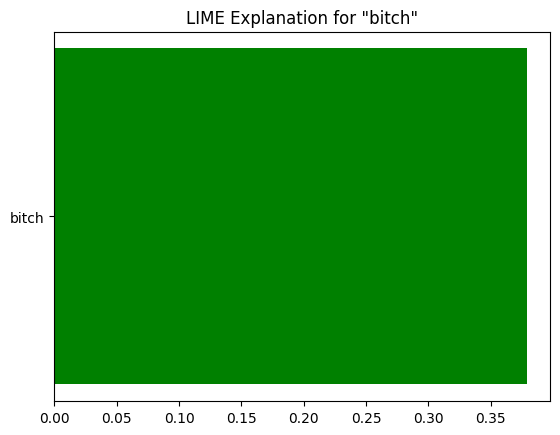

In [29]:
from lime.lime_text import LimeTextExplainer

# Define the class names for your task
class_names = ['Not Hate Speech', 'Hate Speech']

# Function to predict probabilities using the DistilBERT model
def predictor(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
    inputs = inputs.to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probabilities.cpu().numpy()

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# Choose a sample text to explain
sample_text = (input())

# Generate LIME explanation
exp = explainer.explain_instance(sample_text, predictor, num_features=6)

# Display explanation in notebook
exp.show_in_notebook(text=sample_text)

# Optionally visualize the explanation as a plot # Removed extra indent
fig = exp.as_pyplot_figure() # Removed extra indent
plt.title(f'LIME Explanation for "{sample_text}"') # Removed idx, which is out of scope, and replaced with the actual text
plt.show() # Removed extra indent